### Meteorological parameters of the observation period.
Data on air temperature, pressure, humidity in Kourovka site (KAO) for 2022. Since the data has some gaps, we have to fill its with ERA-5 reanalysis data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import glob
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#### 1. 2m-temperature and surface pressure extraction from ERA-5 reanalysis data.

Download ERA-5 reanalysis data. Use cdo command to interpolate data to KAO coordinates:
```
$ cdo remapbil,lon=59.545/lat=57.038 <input.nc> <output.nc> 
```
Then we get required data from .nc files.

In [ ]:
def ncdump(nc_fid, verb=False):
    
    ''' Reads NetCDF-files params '''

    def print_ncattr(key):
        
        try:
            print('\t\ttype:', repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim) 
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [ ]:
#ERA-5 file params:
fname = '/content/drive/MyDrive/Colab Notebooks/Colab data/Ural_Carbon/ERA-5_T-P_surf_jan-nov_2022_KAO.nc'
nc_fid = Dataset(fname, 'r')
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

# Extract data from NetCDF file:

# Temperature from [K] to [Celsius degree]:
T2m = nc_fid.variables['t2m'][:] - 271.15
# Pressure from [Pa] to [hPa]
P = nc_fid.variables['sp'][:]*0.01

# Calculate date and time from initial date:
time = nc_fid.variables['time'][:]
init_time = dt.datetime.strptime('1900-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
loc_hour = 5 # Time shift from UTC to Local
time = [init_time + dt.timedelta(hours=loc_hour) + dt.timedelta(hours=int(t)) for t in time]

# Masked array to simple array (because data obtained by software of diff. versions):
T2m = T2m[:,0,0,0].filled(1)*T2m[:,1,0,0].filled(1)
P = P[:,0,0,0].filled(1)*P[:,1,0,0].filled(1)

# Create dataframe:
era5_data = pd.DataFrame({'time': time, 'temp': T2m, 'pres': P})

# Time to pandas datetime format:
era5_data['time'] = pd.to_datetime(era5_data['time'], format='%Y-%m-%d %H:%M:%S')
era5_data.index = era5_data['time']

display(era5_data)
era5_data.info()
era5_data.describe()

,time,temp,pres
time,,,
2022-01-01 05:00:00,2022-01-01 05:00:00,-6.056617,969.815424
2022-01-01 06:00:00,2022-01-01 06:00:00,-6.485998,968.815205
2022-01-01 07:00:00,2022-01-01 07:00:00,-6.977290,968.100477
2022-01-01 08:00:00,2022-01-01 08:00:00,-7.039201,967.413699
2022-01-01 09:00:00,2022-01-01 09:00:00,-6.714669,966.986460
...,...,...,...
2022-12-01 00:00:00,2022-12-01 00:00:00,-11.242146,993.746828
2022-12-01 01:00:00,2022-12-01 01:00:00,-11.539717,993.664974
2022-12-01 02:00:00,2022-12-01 02:00:00,-11.444854,993.668966


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8016 entries, 2022-01-01 05:00:00 to 2022-12-01 04:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8016 non-null   datetime64[ns]
 1   temp    8016 non-null   float64       
 2   pres    8016 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 250.5 KB


,temp,pres
count,8016.000000,8016.000000
mean,5.958848,971.835320
std,12.226946,9.813279
min,-26.267498,934.863636
25%,-2.220144,966.027666
50%,6.889232,972.470698
75%,15.220728,978.322283
max,31.130806,999.213098


#### 2. Temperature and surface pressure from KAO meteofiles
2.1. We use data from KAO .dat file: __AirT_C_Avg__ - temperature, __BP_mbar_Avg__ - surface pressure. Relative humidity data is not correct, we don't use it.

In [ ]:
file_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/Colab data/MeteoLog_MeteoTable_?[0-9].dat'))

kao_data = pd.concat([pd.read_csv(f, skiprows=4, usecols=[0, 2, 3], names=['time', 'pres', 'temp']) for f in file_list])

# Time to pandas datetime format:
kao_data['time'] = pd.to_datetime(kao_data['time'], format='%Y-%m-%d %H:%M:%S')
kao_data.index = kao_data['time']

display(kao_data)
kao_data.info()

,time,pres,temp
time,,,
2022-02-26 13:35:00,2022-02-26 13:35:00,947.2817,-0.698702
2022-02-26 13:36:00,2022-02-26 13:36:00,993.7040,-0.674794
2022-02-26 13:37:00,2022-02-26 13:37:00,993.7324,-0.625376
2022-02-26 13:38:00,2022-02-26 13:38:00,993.7607,-0.564367
2022-02-26 13:39:00,2022-02-26 13:39:00,993.7532,-0.490539
...,...,...,...
2022-12-24 21:07:00,2022-12-24 21:07:00,984.2574,-0.190058
2022-12-24 21:08:00,2022-12-24 21:08:00,984.2715,-0.210633
2022-12-24 21:09:00,2022-12-24 21:09:00,984.2293,-0.219884


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425134 entries, 2022-02-26 13:35:00 to 2022-12-24 21:11:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    425134 non-null  datetime64[ns]
 1   pres    425134 non-null  float64       
 2   temp    425134 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 13.0 MB


2.2. Compare datasets, average over hours KAO data. NOTICE: KAO data contain NaN, remove it later!

In [ ]:
# Remove invalid pressure values:
kao_data = kao_data.loc[kao_data['pres'] > era5_data['pres'].min()]
kao_data = kao_data.resample("H").mean()

2.3. Plot temperature and pressure.

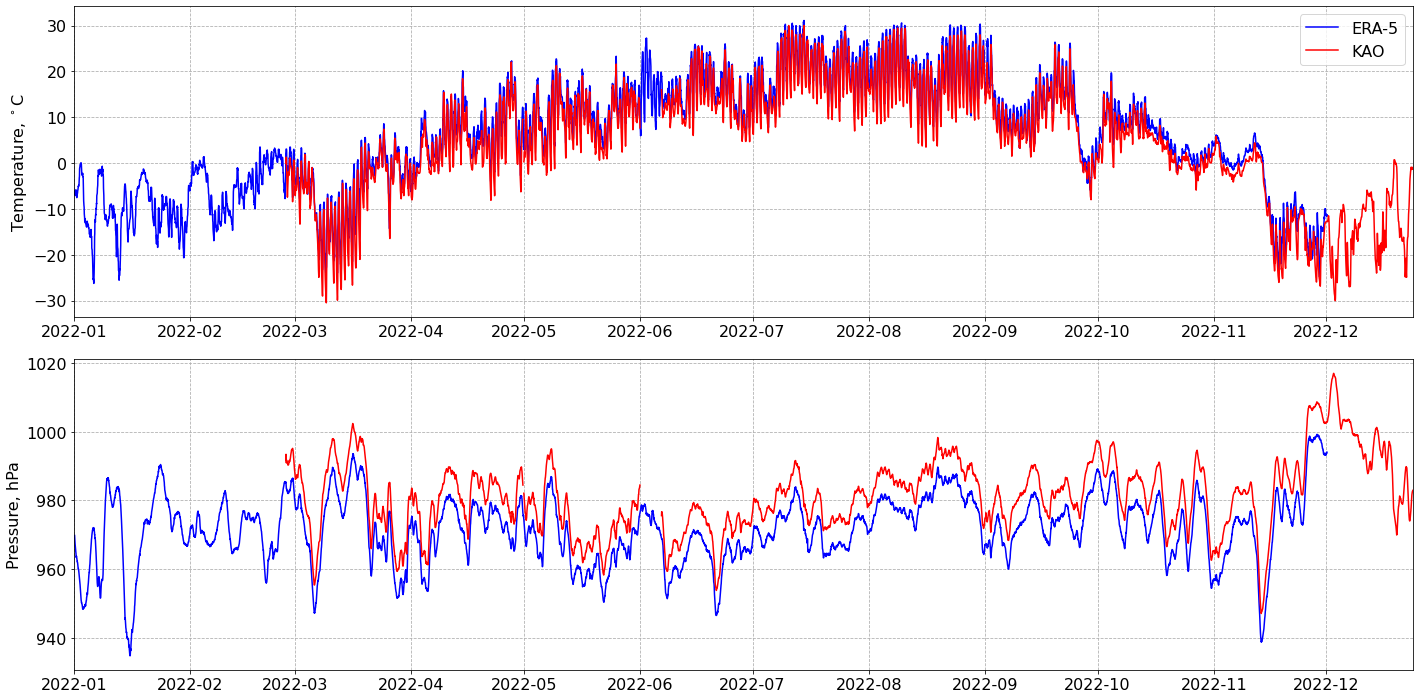

In [ ]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(2, 1, figsize = (20,10))
ax[0].plot(era5_data['temp'], color='blue', label='ERA-5')
ax[0].plot(kao_data['temp'], color='red', label='KAO')
ax[1].plot(era5_data['pres'], color='blue')
ax[1].plot(kao_data['pres'], color='red')
ax[0].set_ylabel('Temperature, $^\circ$C')
ax[1].set_ylabel('Pressure, hPa')
ax[0].set_xlim([dt.date(2022,1,1),dt.date(2022,12,24)])
ax[1].set_xlim([dt.date(2022,1,1),dt.date(2022,12,24)])
ax[0].legend(frameon = True)
fig.tight_layout()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')

#### 3. Correction of ERA-5 data and filling gaps in KAO site measurements.

3.1. Compare data.

In [ ]:
# Join data by index:
kao_data.dropna(inplace=True) # Now remove NaN
met = kao_data.join(era5_data, how='inner', lsuffix='_kao', rsuffix='_era5')
display(met)

,pres_kao,temp_kao,time,temp_era5,pres_era5
time,,,,,
2022-02-26 13:00:00,991.794680,-0.054195,2022-02-26 13:00:00,2.126593,985.034336
2022-02-26 14:00:00,993.421800,0.681403,2022-02-26 14:00:00,2.397204,984.998399
2022-02-26 15:00:00,992.458327,1.292909,2022-02-26 15:00:00,3.067238,984.157896
2022-02-26 16:00:00,990.928541,1.176023,2022-02-26 16:00:00,3.050263,983.544986
2022-02-26 17:00:00,991.759217,-0.041150,2022-02-26 17:00:00,3.052260,983.546983
...,...,...,...,...,...
2022-12-01 00:00:00,1002.723883,-12.691716,2022-12-01 00:00:00,-11.242146,993.746828
2022-12-01 01:00:00,1002.875517,-12.666243,2022-12-01 01:00:00,-11.539717,993.664974
2022-12-01 02:00:00,1002.823017,-12.668887,2022-12-01 02:00:00,-11.444854,993.668966


In [ ]:
# Use sklearn:

# Pressure:
X_p = met[['pres_kao']].values
Y_p = met['pres_era5'].values
model = LinearRegression().fit(X_p, Y_p)
Y_p_mod = model.predict(X_p)
r2 = model.score(X_p, Y_p)
coef_p = model.coef_[0]
intercept_p = model.intercept_
print('Pressure:')
print(f'Slope: {model.coef_[0]:.2f}  Intercept: {model.intercept_:.2f}  R-squared: {r2:.2f}')

# Temperature:
X_t = met[['temp_kao']].values
Y_t = met['temp_era5'].values
model = LinearRegression().fit(X_t, Y_t)
Y_t_mod = model.predict(X_t)
r2 = model.score(X_t, Y_t)
coef_t = model.coef_[0]
intercept_t = model.intercept_
print('Temperature:')
print(f'Slope: {model.coef_[0]:.2f}  Intercept: {model.intercept_:.2f}  R-squared: {r2:.2f}')

Pressure:
Slope: 0.98  Intercept: 10.70  R-squared: 1.00
Temperature:
Slope: 0.97  Intercept: 2.29  R-squared: 0.98


Text(0.5, 1.0, 'ERA-5 - KAO, temperature')

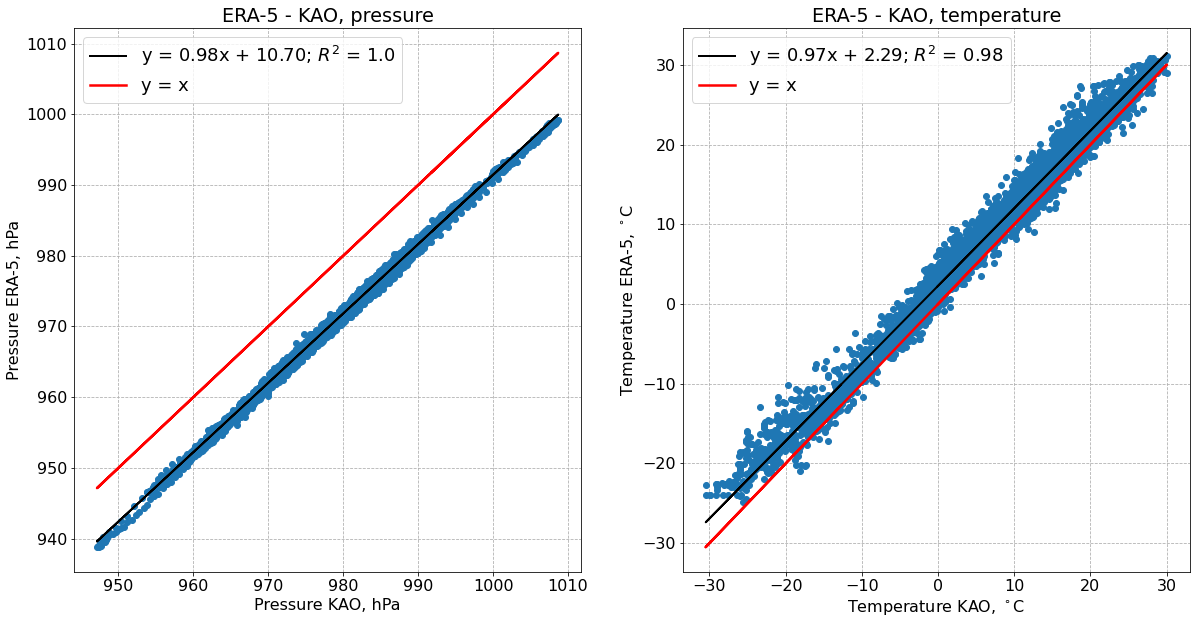

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(met['pres_kao'], met['pres_era5'], 'o')
ax[0].plot(X_p, Y_p_mod, color='black', lw=2, label=f'y = {coef_p:.2f}x + {intercept_p:.2f}; $R^2$ = 1.0')
ax[0].plot(X_p, X_p, color='red', lw=2.5, label='y = x')
ax[0].grid(linestyle='--')
ax[0].legend(fontsize=18)
ax[0].set_xlabel('Pressure KAO, hPa')
ax[0].set_ylabel('Pressure ERA-5, hPa')
ax[1].plot(met['temp_kao'], met['temp_era5'], 'o')
ax[1].plot(X_t, Y_t_mod, color='black', lw=2, label=f'y = {coef_t:.2f}x + {intercept_t:.2f}; $R^2$ = 0.98')
ax[1].plot(X_t, X_t, color='red', lw=2.5, label='y = x')
ax[1].grid(linestyle='--')
ax[1].legend(fontsize=18)
ax[1].set_xlabel('Temperature KAO, $^\circ$C')
ax[1].set_ylabel('Temperature ERA-5, $^\circ$C')
ax[0].set_title('ERA-5 - KAO, pressure')
ax[1].set_title('ERA-5 - KAO, temperature')

In [ ]:
# Correct met and era5_data dataframes:
met['pres_era5_cor'] = met['pres_era5'] + ((met['pres_kao'] - met['pres_era5']).mean())
met['temp_era5_cor'] = met['temp_era5'] + ((met['temp_kao'] - met['temp_era5']).mean())
era5_data['pres'] = era5_data['pres'] + ((met['pres_kao'] - met['pres_era5']).mean())
era5_data['temp'] = era5_data['temp'] + ((met['temp_kao'] - met['temp_era5']).mean())
display(met)
display(era5_data)
print((met['temp_kao'] - met['temp_era5']).mean())
print((met['pres_kao'] - met['pres_era5']).mean())

,pres_kao,temp_kao,time,temp_era5,pres_era5,pres_era5_cor,temp_era5_cor
time,,,,,,,
2022-02-26 13:00:00,991.794680,-0.054195,2022-02-26 13:00:00,2.126593,985.034336,993.204349,0.015260
2022-02-26 14:00:00,993.421800,0.681403,2022-02-26 14:00:00,2.397204,984.998399,993.168413,0.285871
2022-02-26 15:00:00,992.458327,1.292909,2022-02-26 15:00:00,3.067238,984.157896,992.327909,0.955905
2022-02-26 16:00:00,990.928541,1.176023,2022-02-26 16:00:00,3.050263,983.544986,991.715000,0.938930
2022-02-26 17:00:00,991.759217,-0.041150,2022-02-26 17:00:00,3.052260,983.546983,991.716997,0.940927
...,...,...,...,...,...,...,...
2022-12-01 00:00:00,1002.723883,-12.691716,2022-12-01 00:00:00,-11.242146,993.746828,1001.916842,-13.353479
2022-12-01 01:00:00,1002.875517,-12.666243,2022-12-01 01:00:00,-11.539717,993.664974,1001.834987,-13.651050
2022-12-01 02:00:00,1002.823017,-12.668887,2022-12-01 02:00:00,-11.444854,993.668966,1001.838980,-13.556187


,time,temp,pres
time,,,
2022-01-01 05:00:00,2022-01-01 05:00:00,-8.167950,977.985438
2022-01-01 06:00:00,2022-01-01 06:00:00,-8.597331,976.985218
2022-01-01 07:00:00,2022-01-01 07:00:00,-9.088623,976.270491
2022-01-01 08:00:00,2022-01-01 08:00:00,-9.150534,975.583713
2022-01-01 09:00:00,2022-01-01 09:00:00,-8.826002,975.156473
...,...,...,...
2022-12-01 00:00:00,2022-12-01 00:00:00,-13.353479,1001.916842
2022-12-01 01:00:00,2022-12-01 01:00:00,-13.651050,1001.834987
2022-12-01 02:00:00,2022-12-01 02:00:00,-13.556187,1001.838980


-2.1113329399324154
8.170013782102012


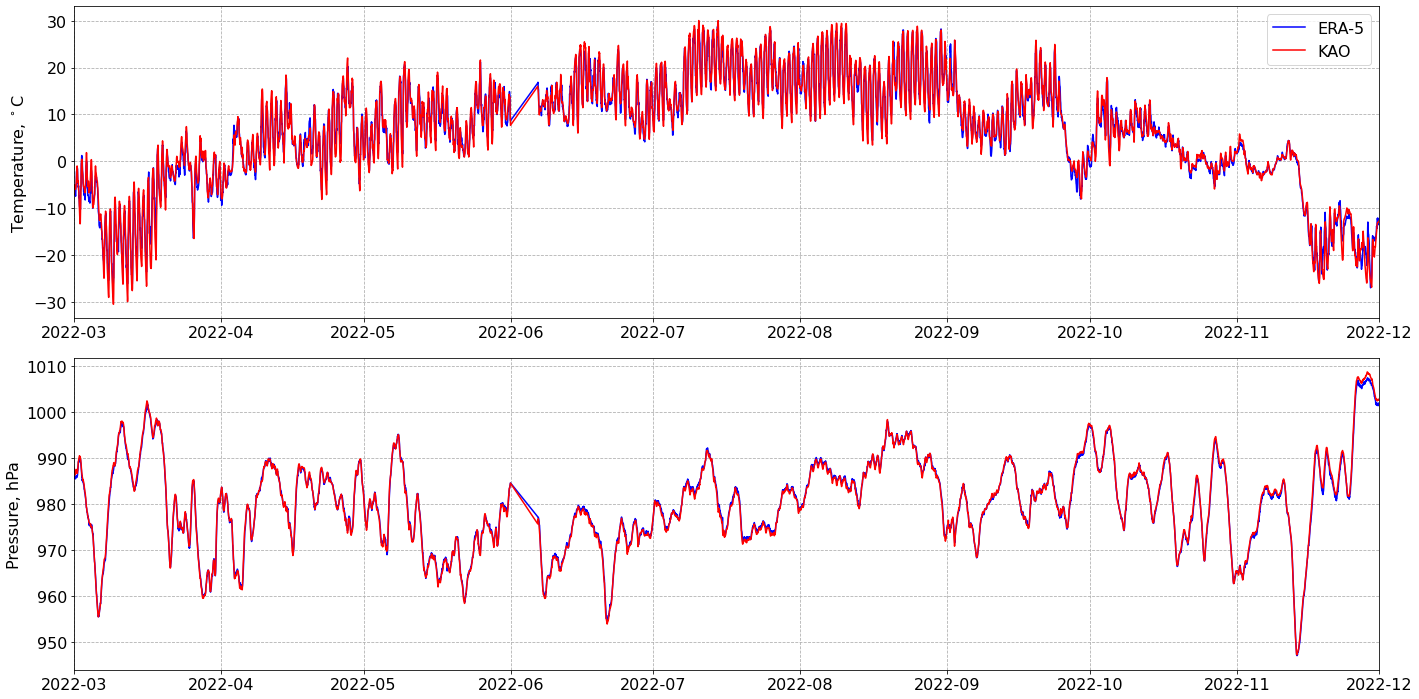

In [ ]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(2, 1, figsize = (20,10))
ax[0].plot(met['temp_era5_cor'], color='blue', label='ERA-5')
ax[0].plot(met['temp_kao'], color='red', label='KAO')
ax[1].plot(met['pres_era5_cor'], color='blue')
ax[1].plot(met['pres_kao'], color='red')
ax[0].set_ylabel('Temperature, $^\circ$C')
ax[1].set_ylabel('Pressure, hPa')
ax[0].set_xlim([dt.date(2022,3,1),dt.date(2022,12,1)])
ax[1].set_xlim([dt.date(2022,3,1),dt.date(2022,12,1)])
ax[0].legend(frameon = True)
fig.tight_layout()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')

3.2. Afrer correction.

In [ ]:
# Pressure:
X_p = met[['pres_kao']].values
Y_p = met['pres_era5_cor'].values
model = LinearRegression().fit(X_p, Y_p)
Y_p_mod = model.predict(X_p)
r2 = model.score(X_p, Y_p)
coef_p = model.coef_[0]
intercept_p = model.intercept_
print('Pressure:')
print(f'Slope: {model.coef_[0]:.2f}  Intercept: {model.intercept_:.2f}  R-squared: {r2:.2f}')

# Temperature:
X_t = met[['temp_kao']].values
Y_t = met['temp_era5_cor'].values
model = LinearRegression().fit(X_t, Y_t)
Y_t_mod = model.predict(X_t)
r2 = model.score(X_t, Y_t)
coef_t = model.coef_[0]
intercept_t = model.intercept_
print('Temperature:')
print(f'Slope: {model.coef_[0]:.2f}  Intercept: {model.intercept_:.2f}  R-squared: {r2:.2f}')

Pressure:
Slope: 0.98  Intercept: 18.87  R-squared: 1.00
Temperature:
Slope: 0.97  Intercept: 0.17  R-squared: 0.98


Text(0.5, 1.0, 'ERA-5 - KAO, ERA-5 corr., temperature')

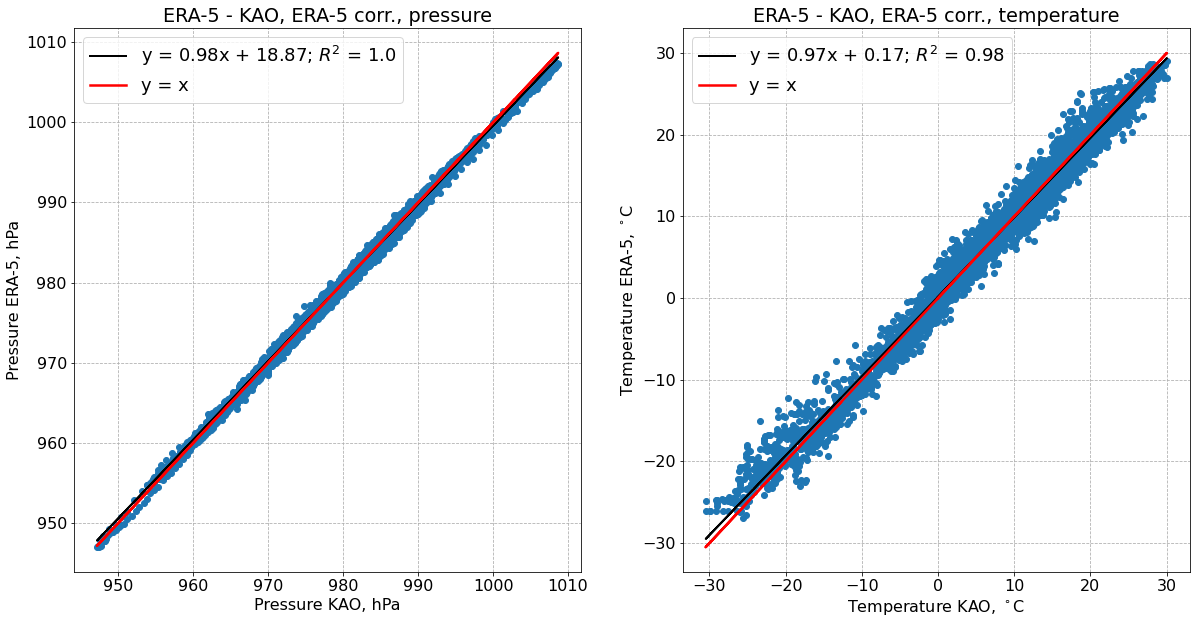

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(met['pres_kao'], met['pres_era5_cor'], 'o')
ax[0].plot(X_p, Y_p_mod, color='black', lw=2, label=f'y = {coef_p:.2f}x + {intercept_p:.2f}; $R^2$ = 1.0')
ax[0].plot(X_p, X_p, color='red', lw=2.5, label='y = x')
ax[0].grid(linestyle='--')
ax[0].legend(fontsize=18)
ax[0].set_xlabel('Pressure KAO, hPa')
ax[0].set_ylabel('Pressure ERA-5, hPa')
ax[1].plot(met['temp_kao'], met['temp_era5_cor'], 'o')
ax[1].plot(X_t, Y_t_mod, color='black', lw=2, label=f'y = {coef_t:.2f}x + {intercept_t:.2f}; $R^2$ = 0.98')
ax[1].plot(X_t, X_t, color='red', lw=2.5, label='y = x')
ax[1].grid(linestyle='--')
ax[1].legend(fontsize=18)
ax[1].set_xlabel('Temperature KAO, $^\circ$C')
ax[1].set_ylabel('Temperature ERA-5, $^\circ$C')
ax[0].set_title('ERA-5 - KAO, ERA-5 corr., pressure')
ax[1].set_title('ERA-5 - KAO, ERA-5 corr., temperature')

#### 4. Plot corrected data + relative humidity from ERA-5.

In [ ]:
tmp = era5_data.join(kao_data, how='outer', lsuffix='_era5', rsuffix='_kao')

In [ ]:
# Fill gaps in dataframe:
tmp['temp_era5-kao'] = tmp['temp_era5']
tmp['pres_era5-kao'] = tmp['pres_era5']
tmp['temp_era5-kao'].loc[~tmp['temp_kao'].isna()] = np.nan
tmp['pres_era5-kao'].loc[~tmp['pres_kao'].isna()] = np.nan
tmp['temp_full'] = tmp['temp_kao']
tmp['temp_full'].loc[tmp['temp_full'].isna()] = tmp['temp_era5']
tmp['pres_full'] = tmp['pres_kao']
tmp['pres_full'].loc[tmp['pres_full'].isna()] = tmp['pres_era5']
tmp.drop(['time', 'temp_era5', 'pres_era5'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Extract relative humidity data. To interpolate data to KAO coordinates we also used __cdo__ commands:
```
$ cdo remapbil,lon=59.545/lat=57.038 <input.nc> <output_1.nc> 
$ cdo intlevel,1000.0 output_1.nc output_2.nc
```

In [ ]:
hum_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/Colab data/Ural_Carbon/ERA-5_RH_level_01-03-2022_mod.nc/ERA-5_RH*'))

# Create dataframe:
era5_hum_data = pd.DataFrame(columns=['time', 'hum_era5'])

for file in hum_list:
    
    nc_fid = Dataset(file, 'r')
    nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

    # Calculate date and time from initial date:
    time = nc_fid.variables['time'][:]
    init_time = dt.datetime.strptime('1900-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
    loc_hour = 5 # Time shift from UTC to Local
    time = [init_time + dt.timedelta(hours=loc_hour) + dt.timedelta(hours=int(t)) for t in time]

    # Relative humidity in %:
    hum = nc_fid.variables['r'][:]
    df = pd.DataFrame({'time': time, 'hum_era5': hum[:,0,0,0]})
    era5_hum_data =  pd.concat([era5_hum_data, df], axis=0)

# Time to pandas datetime format:
era5_hum_data['time'] = pd.to_datetime(era5_hum_data['time'], format='%Y-%m-%d %H:%M:%S')
era5_hum_data.index = era5_hum_data['time']
era5_hum_data.drop('time', axis=1, inplace=True)

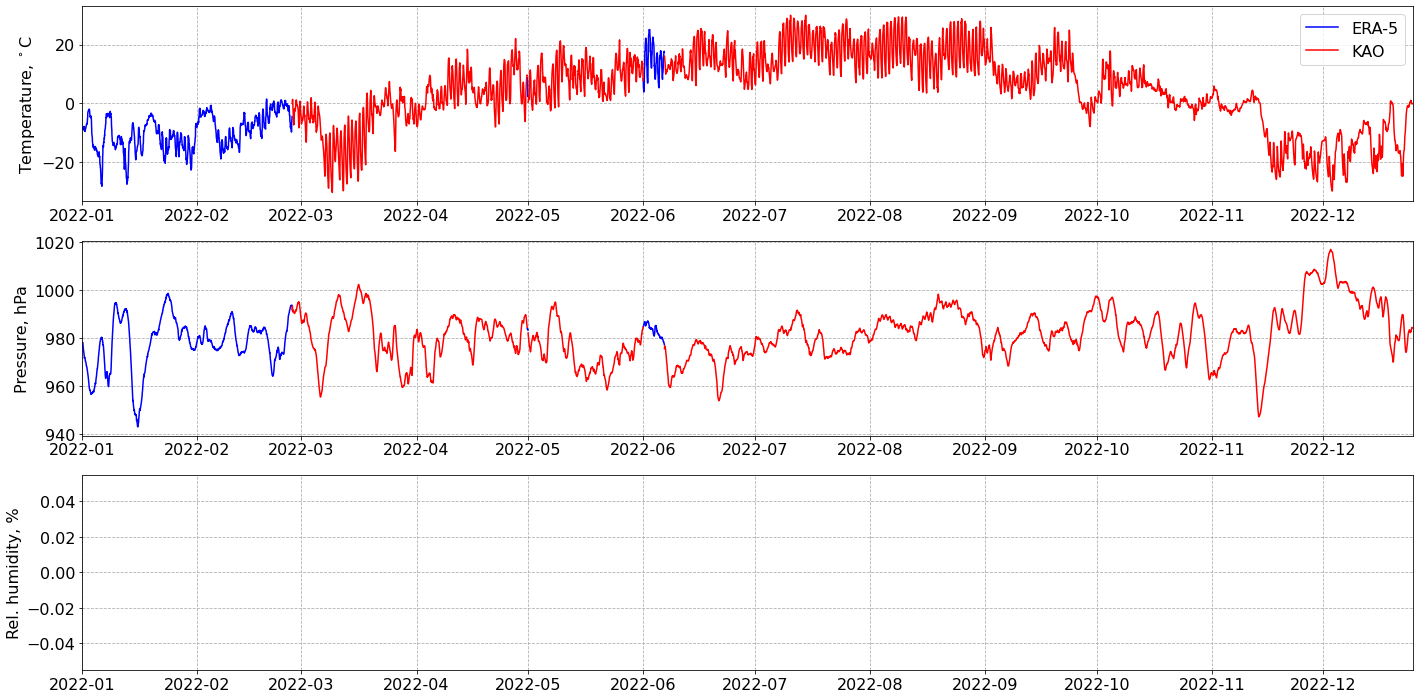

In [ ]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(3, 1, figsize = (20,10))
ax[0].plot(tmp['temp_era5-kao'], color='blue', label='ERA-5')
ax[0].plot(tmp['temp_kao'], color='red', label='KAO')
ax[1].plot(tmp['pres_era5-kao'], color='blue')
ax[1].plot(tmp['pres_kao'], color='red')

ax[2].plot(era5_hum_data['hum_era5'], color='blue')

ax[0].set_ylabel('Temperature, $^\circ$C')
ax[1].set_ylabel('Pressure, hPa')
ax[2].set_ylabel('Rel. humidity, %')
ax[0].set_xlim([dt.date(2022,1,1),dt.date(2022,12,25)])
ax[1].set_xlim([dt.date(2022,1,1),dt.date(2022,12,25)])
ax[2].set_xlim([dt.date(2022,1,1),dt.date(2022,12,25)])
ax[0].legend(frameon = True)
fig.tight_layout()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
ax[2].grid(linestyle='--')

#### 5. Save data.

In [ ]:
# tmp2 = tmp.join(era5_hum_data, how='left')
# tmp2.to_csv('Meteo_data.csv', columns=['temp_full', 'pres_full', 'hum_era5'], na_rep='NaN')

#### 6. Rain data (in mm).

In [ ]:
file_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/Colab data/MeteoLog_RainTable_?[0-9].dat'))

kao_rain = pd.concat([pd.read_csv(f, skiprows=4, usecols=[0, 2], names=['time', 'mm']) for f in file_list])
# Time to pandas datetime format:
kao_rain['time'] = pd.to_datetime(kao_rain['time'], format='%Y-%m-%d %H:%M:%S')
kao_rain.index = kao_rain['time']
kao_rain.drop('time', axis=1, inplace=True)
kao_rain_d = kao_rain.resample('d').sum()
kao_rain_m = kao_rain.resample('m').sum()
kao_rain_m.index = pd.to_datetime(kao_rain_m.index.strftime('%Y-%m'))

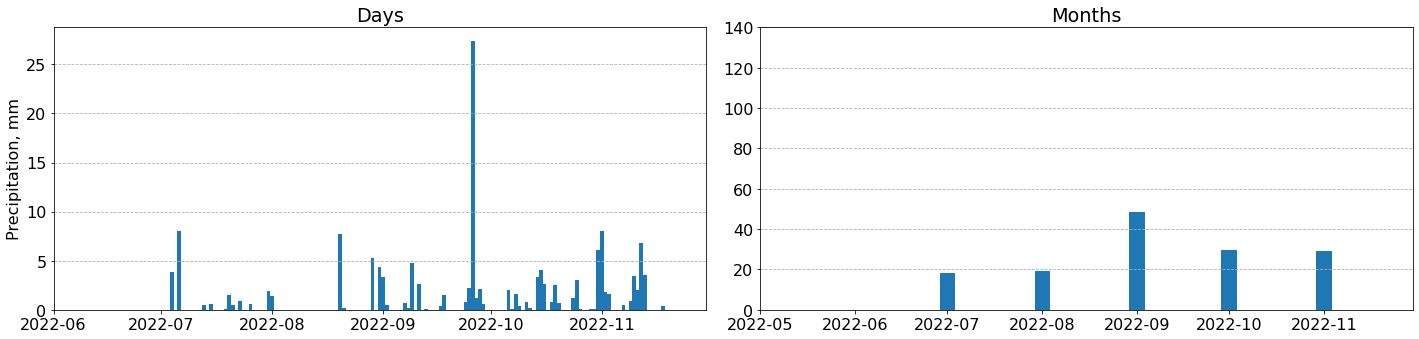

In [ ]:
plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

ax[0].bar(kao_rain_d.index, kao_rain_d['mm'], width=1)
ax[0].set_xlim([dt.date(2022,6,1),dt.date(2022,11,30)])
ax[0].set_ylabel('Precipitation, mm')
ax[0].set_title('Days')
ax[0].grid(axis='y', linestyle='--')

ax[1].bar(kao_rain_m.index, kao_rain_m['mm'], width=5)
ax[1].set_xlim([dt.date(2022,5,1),dt.date(2022,11,30)])
ax[1].set_ylim([0, 140])
ax[1].grid(axis='y', linestyle='--')
ax[1].set_title('Months')
fig.tight_layout()